<a href="https://colab.research.google.com/github/vishwaraghava009/Volkswagen-CO2-scandal-imapact-analysis/blob/main/Volkswagen_CO2_scandal_imapact_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Impact of Volkswagen's CO2 scandal on the stock price.

In September 2015, a scandal broke out in the automotive industry. It was found out that Volkswagen companies were misleading customers. The company declared that the cars were far less
polluting than what they actually were. The company lost it's stock value.

This notebook is an attempt to measure the imapct of the scandal on the stock price of Volkswagen using Causal impact.

The workflow is as follows:



1. Set up the libraries.
2. Get the Volkswagen stock details.
3. Pick the Control Group
4. Correaltion Matrix.
5. Measure the impact
6. Analysis.

## 1. Libraries, Directories and Data

The libraries, `yfinance` and `tfcasualimpact` are not available on Google Colab, so, let's install them first!

In [52]:
!pip install yfinance
!pip install tfcausalimpact

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now, let's import the installed libraries.

In [53]:
import yfinance as yf
from causalimpact import CausalImpact
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## 2. Volkswagen stock details.

Now, let's selcet the start, end of both training and treatment periods.

In [54]:
train_start = "2013-12-30"
train_end = "2015-08-24"
treatment_start = "2015-09-07"
treatment_end = "2015-09-28"
end_stock = "2015-10-01"

We have to download the stocks of Volkswagen from the `yfinance` library.

In [55]:
y = ["VOW.DE"]
y = yf.download(tickers = y,
                start = train_start,
                end = end_stock,
                interval = "1wk")
y.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-30,195.899994,197.949997,192.649994,192.800003,124.266907,149193
2014-01-06,193.800003,197.500000,190.750000,194.899994,125.620430,369610
2014-01-13,195.649994,197.850006,189.699997,197.350006,127.199570,468531
2014-01-20,196.350006,197.899994,184.899994,185.000000,119.239510,434638
2014-01-27,185.000000,189.899994,177.300003,180.350006,116.242432,514920


We can consider any of the KPI's but `Adj Close` is the most reasonable on eto consider in case of stocks.

So, let's just consider the `Adj Close` column of `y` and rename it `Volks`

In [56]:
y = y['Adj Close'].rename("Volks")
y.head()

Date
2013-12-30    124.266907
2014-01-06    125.620430
2014-01-13    127.199570
2014-01-20    119.239510
2014-01-27    116.242432
Name: Volks, dtype: float64

Alright! Now, Let's move to the next step of the workflow.

## 3. Control Groups

In general, the control groups should not be from the same sector as of our `y`.

So, let's consider the follwing stocks from diffrent sectors:
* Nike, Inc. (NKE)
* McDonald's Corporation (MCD)
* Starbucks Corporation (SBUX)
* JPMorgan Chase & Co. (JPM)
* Bank of America Corporation (BAC)
* Wells Fargo & Company (WFC)
* Microsoft Corporation (MSFT)
* Amazon.com, Inc. (AMZN)
* Alphabet Inc. (GOOGL)
* META, Inc. (META)

Let's download the above mentioned stocks.

In [57]:
stocks = ["NKE", "MCD", "SBUX", "JPM", "BAC", "WFC", "MSFT", "AMZN", "GOOGL", "META"]
X = yf.download(tickers = stocks,
                start = train_start,
                end = end_stock,
                interval = "1wk")
X.head()

[*********************100%***********************]  10 of 10 completed


Adj Close                                                         \
                 AMZN        BAC      GOOGL        JPM        MCD       META   
Date                                                                           
2013-12-30  19.822001  13.785594  27.652653  45.005775  74.965187  54.560001   
2014-01-06  19.882999  14.088021  28.282784  45.168842  74.390533  57.939999   
2014-01-13  19.980499  14.289639  28.792042  44.875397  73.714989  56.299999   
2014-01-20  19.379999  13.819198  28.123875  42.543205  73.326706  54.450001   
2014-01-27  17.934500  14.071220  29.553804  42.751705  73.124817  62.570000   

                                                        ...     Volume  \
                 MSFT        NKE       SBUX        WFC  ...       AMZN   
Date                                                    ...              
2013-12-30  31.209322  35.183208  32.370228  34.535992  ...  176632000   
2014-01-06  30.473696  34.682728  32.673126  34.993023  ...  243712000   
2014-01-13  30.761175  33.091072  31.507879  35.335808  ...  299392000   
2014-01-20  31.124788  32.306511  31.541534  34.642635  ...  253328000   
2014-01-27  31.995693  32.847591  29.917757  34.535992  ...  736846000   

                                                                             \
                  BAC      GOOGL        JPM       MCD       META       MSFT   
Date                                                                          
2013-12-30  392039400  243040716   49674900  10745000  192824900   95561000   
2014-01-06  514474100  431264304   76026700  30795500  337445200  216443300   
2014-01-13  776990400  449026524  128857900  24189300  209568900  216624000   
2014-01-20  423048800  375340284   88049500  25529900  213174600  173821100   
2014-01-27  588251100  783271944  102640100  29263800  453084400  261570800   

                                           
                 NKE      SBUX        WFC  
Date                                       
2013-12-30  19310800  25781800   56591800  
2014-01-06  31083800  43754600   85803200  
2014-01-13  36623000  63968200  104893700  
2014-01-20  39288200  95729000   67291800  
2014-01-27  50060000  72695000   97744500  

[5 rows x 60 columns]

Again! we need only `Adj Close` column.

In [58]:
X = X.iloc[:,:len(stocks)]
X.columns = X.columns.droplevel()
X.head()

,AMZN,BAC,GOOGL,JPM,MCD,META,MSFT,NKE,SBUX,WFC
Date,,,,,,,,,,
2013-12-30,19.822001,13.785594,27.652653,45.005775,74.965187,54.560001,31.209322,35.183208,32.370228,34.535992
2014-01-06,19.882999,14.088021,28.282784,45.168842,74.390533,57.939999,30.473696,34.682728,32.673126,34.993023
2014-01-13,19.980499,14.289639,28.792042,44.875397,73.714989,56.299999,30.761175,33.091072,31.507879,35.335808
2014-01-20,19.379999,13.819198,28.123875,42.543205,73.326706,54.450001,31.124788,32.306511,31.541534,34.642635
2014-01-27,17.934500,14.071220,29.553804,42.751705,73.124817,62.570000,31.995693,32.847591,29.917757,34.535992


Okay! Now, let's append the column `Volks` from `y` to `X`. Also, drop the NaN values.

In [59]:
X.index = X.index.tz_localize(None)
df = pd.concat([y, X], axis = 1).dropna()
df.head()

,Volks,AMZN,BAC,GOOGL,JPM,MCD,META,MSFT,NKE,SBUX,WFC
Date,,,,,,,,,,,
2013-12-30,124.266907,19.822001,13.785594,27.652653,45.005775,74.965187,54.560001,31.209322,35.183208,32.370228,34.535992
2014-01-06,125.620430,19.882999,14.088021,28.282784,45.168842,74.390533,57.939999,30.473696,34.682728,32.673126,34.993023
2014-01-13,127.199570,19.980499,14.289639,28.792042,44.875397,73.714989,56.299999,30.761175,33.091072,31.507879,35.335808
2014-01-20,119.239510,19.379999,13.819198,28.123875,42.543205,73.326706,54.450001,31.124788,32.306511,31.541534,34.642635
2014-01-27,116.242432,17.934500,14.071220,29.553804,42.751705,73.124817,62.570000,31.995693,32.847591,29.917757,34.535992


OKay! Now, let's look for the correlation between different stock values.

## 4. Correlation Matrix

Correlation should be observed only in the training period.

In [60]:
df_training = df[df.index <= train_end]
df_training.tail()

,Volks,AMZN,BAC,GOOGL,JPM,MCD,META,MSFT,NKE,SBUX,WFC
Date,,,,,,,,,,,
2015-07-27,123.860626,26.807501,15.222455,32.875000,55.055374,81.617912,94.010002,41.122784,52.881039,49.810066,45.914165
2015-08-03,128.907898,26.131001,15.111779,33.219501,54.669750,80.849602,94.300003,41.158005,52.555176,49.182369,45.596806
2015-08-10,121.135078,26.576000,15.069212,34.468498,54.541206,81.135674,94.419998,41.386955,52.486340,49.231777,45.782665
2015-08-17,111.040497,24.723499,13.707023,32.201500,51.094723,79.386597,86.059998,37.926300,49.048759,45.558781,43.099426
2015-08-24,114.741844,25.900499,13.928380,32.984501,51.520508,78.667343,91.010002,38.938690,51.632671,47.964325,42.756050


let's plot the correlation matrix.

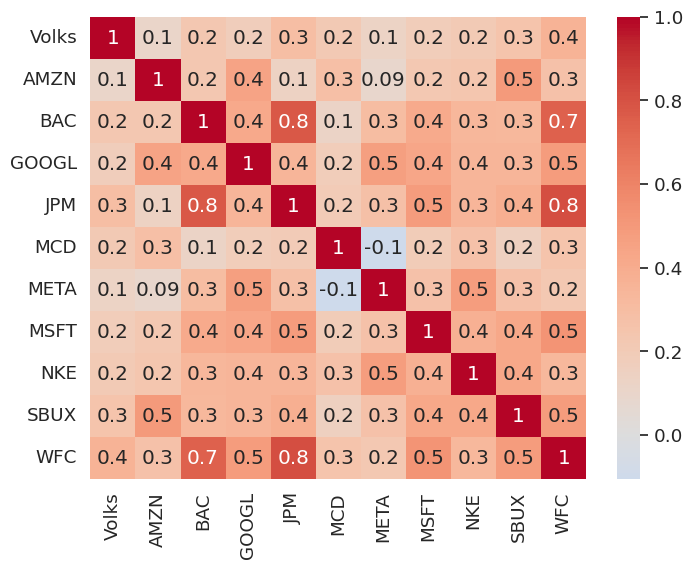

In [61]:
#Heatmap
plt.figure(figsize = (8,6))
sns.set(font_scale = 1.2)
sns.heatmap(data = df_training.pct_change().dropna().corr(),
            annot = True,
            fmt = '.1g',
            cmap = 'coolwarm',
            center = 0);

By observing the correlation matrix we could not see a great correlation of Volkswagen with any other company.

But, let's go with all the stocks whose correlation is greter than or equal to 0.2 with Volkswagen.

In [62]:
df_final = df.drop(columns = ["META", "AMZN"])
df_final.head()

,Volks,BAC,GOOGL,JPM,MCD,MSFT,NKE,SBUX,WFC
Date,,,,,,,,,
2013-12-30,124.266907,13.785594,27.652653,45.005775,74.965187,31.209322,35.183208,32.370228,34.535992
2014-01-06,125.620430,14.088021,28.282784,45.168842,74.390533,30.473696,34.682728,32.673126,34.993023
2014-01-13,127.199570,14.289639,28.792042,44.875397,73.714989,30.761175,33.091072,31.507879,35.335808
2014-01-20,119.239510,13.819198,28.123875,42.543205,73.326706,31.124788,32.306511,31.541534,34.642635
2014-01-27,116.242432,14.071220,29.553804,42.751705,73.124817,31.995693,32.847591,29.917757,34.535992


All ready! It's time to measure the impact.

## Google Causal Impact.

First, let's declare the pre and post periods.

In [63]:
pre_period = [train_start, train_end]
post_period = [treatment_start, treatment_end]

And measure the impact!

In [64]:
impact = CausalImpact(data = df_final,
                      pre_period = pre_period,
                      post_period = post_period)

Finally, let's visualize the imapct.

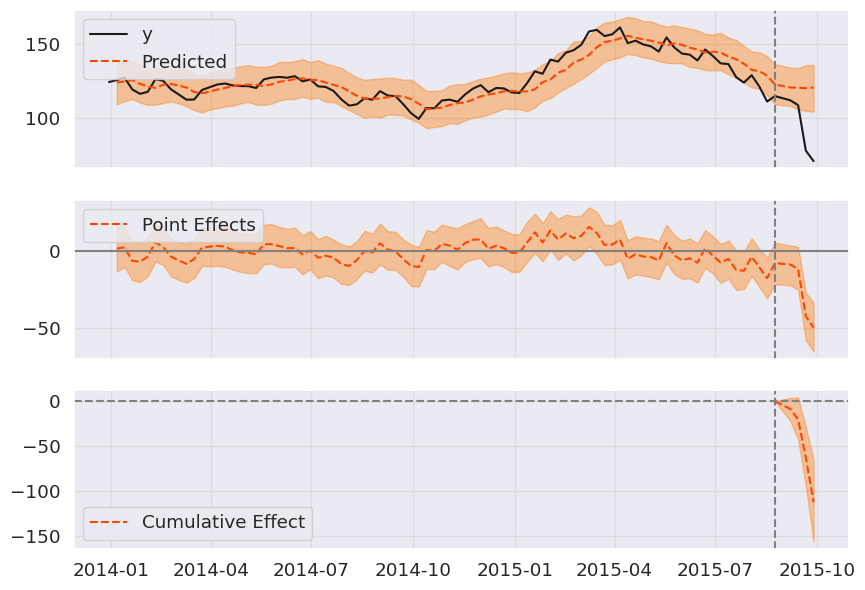

In [65]:
impact.plot()

Out of the three plots,
* `Point effects` graph is the one we are concerned about because it is basically the diffrence between the predicted stocks and the stocks having impact.

* `Cumulative effect` is the sum of cumulative effect on the stocks. But in this particular case stocks are relative so going for cumulative effect is a dumb move!

Clearly, we could see a drastic decrease in `delta` in `Point effects` graph, implying the impact.

Now, let's see the summary of impact.

## Analysis

In [66]:
#summary
print(impact.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    92.23              368.92
Prediction (s.d.)         120.38 (5.54)      481.53 (22.17)
95% CI                    [109.27, 130.99]   [437.07, 523.96]

Absolute effect (s.d.)    -28.15 (5.54)      -112.61 (22.17)
95% CI                    [-38.76, -17.04]   [-155.04, -68.14]

Relative effect (s.d.)    -23.38% (4.6%)     -23.38% (4.6%)
95% CI                    [-32.2%, -14.15%]  [-32.2%, -14.15%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


For the better understanding of the above summary we an refer to the below cell.



But we are concerened about the `Average` values only not the `Cumulative` values.

In [67]:
print(impact.summary('report'))

Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 92.23. By contrast, in the absence of an
intervention, we would have expected an average response of 120.38.
The 95% interval of this counterfactual prediction is [109.27, 130.99].
Subtracting this prediction from the observed response yields
an estimate of the causal effect the intervention had on the
response variable. This effect is -28.15 with a 95% interval of
[-38.76, -17.04]. For a discussion of the significance of this effect,
see below.


Summing up the individual data points during the post-intervention
period (which can only sometimes be meaningfully interpreted), the
response variable had an overall value of 368.92.
By contrast, had the intervention not taken place, we would have expected
a sum of 481.53. The 95% interval of this prediction is [437.07, 523.96].


The above results are given in terms of absolute numbers. In relative
terms, the response 